# Parsing

Для данного задания буду парсить новостной сайт тематики видеоигр, фильмов и сериалов, который я любил читать в подростковом возрасте.

In [1]:
import numpy as np
import pandas as pd

import sys

import requests
from bs4 import BeautifulSoup
import dateparser
import time

import nltk
import pymorphy2
import re
from tqdm import tqdm
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
url = "https://gamebomb.ru/news"
page_param = "page="

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

news_data_dict = {
    "url": [],
    "title": [],
    "text": [],
    "datetime": [],
    "count_views": [],
}

# Пройдемся по страницам, пока не соберем 2000 новостей
page_number = 1
max_page_number = 1864
news_count = 0
target_news_count = 2000

while news_count <= target_news_count:
    # Проверка на то, что не ушли за пределы страниц с новостями
    if page_number > max_page_number:
        break
        
    # Получаем html-код стриницы
    page_response = requests.get(url + "?" + page_param + str(page_number), headers=headers)
    page_soup = BeautifulSoup(page_response.text, "html.parser")
    
    news_items = page_soup.find_all("tr", class_="gbnews-listShort")
    
    for news_item in news_items:
        # Получаем ссылку на новость
        news_url_raw = news_item.find("a", class_="img")
        
        if not news_url_raw:
            continue
            
        news_url = news_url_raw.get("href")
       
        # Получаем заголовок новости
        news_title_raw = news_item.find("div", class_="sub").find_next("h3")
        
        if not news_title_raw:
            continue
            
        news_title = news_title_raw.get_text(strip=True)
    
        # Получаем дату публикации новости
        news_datetime_raw = news_item.find("div", class_="sub")
        
        if not news_datetime_raw:
            continue
            
        news_datetime = news_datetime_raw.get_text(strip=True)
        news_datetime_formatted = dateparser.parse(news_datetime).strftime("%Y-%m-%d %H:%M:%S")
        
        # Получаем количество просмотров
        news_views_raw = news_item.find("span", class_="views-bubble")
        
        if not news_views_raw:
            continue
            
        news_views = news_views_raw.get_text(strip=True)
    
        # Открываем страницу с новостью
        news_response = requests.get(news_url, headers=headers)
        news_response.raise_for_status()
        news_soup = BeautifulSoup(news_response.text, "html.parser")
    
        # Получаем текст статьи
        news_text_raw = news_soup.find("div", itemprop="articleBody")
    
        if not news_text_raw:
            continue

        news_text = news_text_raw.get_text(strip=True)
        
        # Сохраним полученные фичи в словарь
        news_data_dict["url"].append(news_url)
        news_data_dict["title"].append(news_title)
        news_data_dict["text"].append(news_text)
        news_data_dict["datetime"].append(news_datetime_formatted)
        news_data_dict["count_views"].append(news_views)
        
        news_count += 1
        
        # Ждем пол секунды, чтобы не вызывать подозрений частотой запросов
        time.sleep(0.5)
                
    page_number += 1


In [10]:
sys.getsizeof(news_data_dict)

232

In [14]:
news_df = pd.DataFrame.from_dict(news_data_dict, orient="columns")
print(news_df.shape)
news_df.head()

(2020, 5)


,url,title,text,datetime,count_views
0,https://gamebomb.ru/gbnews/41500,Дженна Ортега новым фильмом вместо «Уэнсдей 2»...,В сети появилась новая информация по новому фи...,2023-12-03 14:47:00,1315
1,https://gamebomb.ru/gbnews/41499,Новый «Гарри Поттер» Эмму Уотсон с незнакомым ...,"В сети появились новые кадры, на которых предс...",2023-12-03 13:55:00,1873
2,https://gamebomb.ru/gbnews/41498,S.T.A.L.K.E.R. 2 засветили в новом видео и уди...,Компания GSC Game World предстала новый официа...,2023-12-02 14:09:00,3317
3,https://gamebomb.ru/gbnews/41497,Rainbow Six: Siege и еще 3 игры для Steam дают...,Популярный экшен Tom Clancy's Rainbow Six Sieg...,2023-12-02 13:25:00,17148
4,https://gamebomb.ru/gbnews/41496,Новый «Безумный Макс» показал нового главного ...,В сети появился первый официальный трейлер сов...,2023-12-01 12:32:00,3954


In [19]:
news_df.to_csv("news_data.csv", index=False)

# Data preprocessing

Подготовим данные для обучения модели. Будем решать задачу предсказания количества просмотров в день по тексту заголовка. Т.к. пользователи по заголовку статьи определяют, хотят ли они читать весь текст.

In [2]:
# Загрузим сохраненные данные после парсинга
news_df = pd.read_csv("news_data.csv")
news_df.head()

,url,title,text,datetime,count_views
0,https://gamebomb.ru/gbnews/41500,Дженна Ортега новым фильмом вместо «Уэнсдей 2»...,В сети появилась новая информация по новому фи...,2023-12-03 14:47:00,1315
1,https://gamebomb.ru/gbnews/41499,Новый «Гарри Поттер» Эмму Уотсон с незнакомым ...,"В сети появились новые кадры, на которых предс...",2023-12-03 13:55:00,1873
2,https://gamebomb.ru/gbnews/41498,S.T.A.L.K.E.R. 2 засветили в новом видео и уди...,Компания GSC Game World предстала новый официа...,2023-12-02 14:09:00,3317
3,https://gamebomb.ru/gbnews/41497,Rainbow Six: Siege и еще 3 игры для Steam дают...,Популярный экшен Tom Clancy's Rainbow Six Sieg...,2023-12-02 13:25:00,17148
4,https://gamebomb.ru/gbnews/41496,Новый «Безумный Макс» показал нового главного ...,В сети появился первый официальный трейлер сов...,2023-12-01 12:32:00,3954


Для начала посмотрим, как ведет себя целевая переменная.

In [119]:
def calc_days_delta(day1, day2):
    date_format = '%Y-%m-%d %H:%M:%S'
    
    datetime1 = datetime.strptime(day1, date_format)
    datetime2 = datetime.strptime(day2, date_format)
    
    delta_days = abs((datetime1 - datetime2).days)
    
    return delta_days

count_views = [item.count_views for item in news_df.itertuples()]
days_delta = [calc_days_delta(item.datetime, "2023-12-04 23:59:59") for item in news_df.itertuples()]

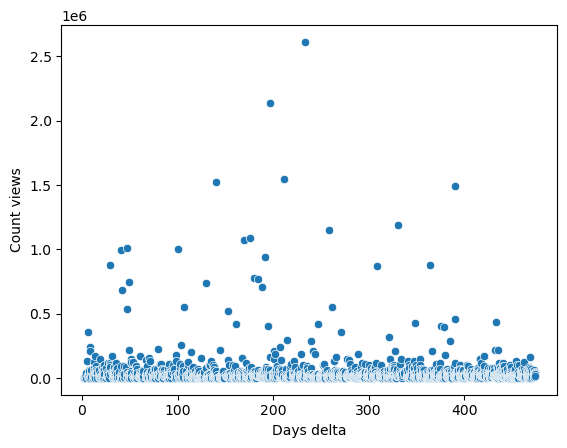

In [120]:
sns.scatterplot(x=days_delta, y=count_views)
plt.xlabel("Days delta")
plt.ylabel("Count views")
plt.show()

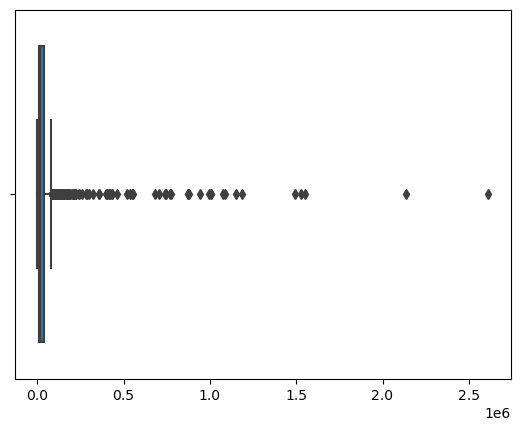

In [124]:
sns.boxplot(x=count_views)
plt.show()

Видно, что большая часть данных концентрируется на маленьких значениях, но есть маленькая часть очень больших выбросов. 

In [130]:
percentile_95 = np.percentile(count_views, 95)
news_df_95 = news_df.loc[news_df["count_views"] <= percentile_95]
news_df_95.shape

(1919, 5)

In [222]:
# Функция для удаления пунктуации и цифр
def words_only(text, regex_pattern=None):
    regex = re.compile(r"[А-Яа-яA-zёЁ]+")
    
    if regex_pattern:
        regex = re.compile(regex_pattern)      

    try:
        return " ".join(regex.findall(text)).lower()
    except:
        return ""
    
# Функция предобработки текстов (удаление стоп слов, пунктуации, цифр и лемматизация)
def process_data(data):
    stop_words = nltk.corpus.stopwords.words("russian")
    word_tokenizer = nltk.WordPunctTokenizer()
    morph = pymorphy2.MorphAnalyzer()
    
    texts = []

    for item in tqdm(data):

        text_lower = words_only(item.title)
        tokens = word_tokenizer.tokenize(text_lower)

        tokens = [word for word in tokens if (word not in all_stop_words and not word.isnumeric())]
        
        tokens_lemmatized = [morph.parse(x)[0].normal_form for x in tokens]

        texts.append(" ".join(tokens_lemmatized))

    return texts

# Функция для вычисления таргета
def calc_mean_views_per_day(count_views, date_publication):
    delta_days = calc_days_delta(datetime_parsed, datetime_publication)
    
    # Обойдем ошибку при делении на 0
    if delta_days == 0:
        delta_days = 1
    
    # Будем считать среднее количество просмотров в день за 7 дней или меньше,
    # для этого вычтем необходимое количество просмотров, если оно превышает наш порог
    treshold = 7
    if delta_days <= treshold:
        return count_views / delta_days
    else:
        return (count_views - ((delta_days - treshold) * (count_views / delta_days))) / treshold

In [223]:
# Обработаем данные и сохраним в отдельные объекты
y_95 = [calc_mean_views_per_day(item.count_views, item.datetime) for item in news_df_95.itertuples()]
texts_95 = process_data(news_df_95.itertuples())

len(count_views_95), len(y_95)

1919it [00:03, 602.86it/s]


(1919, 1919)

In [224]:
print(y_95[:5])
print(texts_95[:5])

[1315.0, 1873.0, 3317.0, 17148.0, 1977.0]
['дженна ортег новый фильм вместо уэнсдея взбесить фанат', 'новый гарри поттер эмма уотсон незнакомый вид показать новый кадр', 's t a l k e r засветить новый видео удивить фанат', 'rainbow six siege игра steam давать бесплатно', 'новый безумный макс показать новый главное герой первый кадр']


In [225]:
# Разобьем полученные тексты на тренировочные и обучающие
train_texts, test_texts, train_y, test_y = train_test_split(texts_95, y_95, test_size=0.2, random_state=42)

In [240]:
# Обучим tf-idf vectorizer на наших текстах, чтобы представить их в виде векторов
vectorizer = TfidfVectorizer(max_features=200, norm=None)
vectorizer.fit(texts_95)

# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['assassin', 'call', 'creed', 'cry', 'cyberpunk', 'dc', 'duty',
       'effect', 'elder', 'far'], dtype=object)

Получается, что наибольший вес имеют названия игр.

In [243]:
def get_word_weight(word, vocabulary, idf_weights):
    word_index = vocabulary.get(word, None)
    
    if word_index is not None:
        word_weight = idf_weights[word_index]
        return f'Вес слова "{word}": {word_weight}'
    else:
        return f'Слово "{word}" не найдено в словаре.'
        
# Посмотрим, какой вес имеют слова с наибольшим весом
print(get_word_weight("бесплатно", vectorizer.vocabulary_, vectorizer.idf_))
print(get_word_weight("assassin", vectorizer.vocabulary_, vectorizer.idf_))
print(get_word_weight("call", vectorizer.vocabulary_, vectorizer.idf_))
print(get_word_weight("elder", vectorizer.vocabulary_, vectorizer.idf_))

Вес слова "бесплатно": 3.508623176405316
Вес слова "assassin": 5.041100047703289
Вес слова "call": 5.939041640909247
Вес слова "elder": 5.939041640909247


In [241]:
train_X = vectorizer.fit_transform(train_texts)
test_X  = vectorizer.transform(test_texts)

# Model building

In [234]:
linreg = LinearRegression()
linreg.fit(train_X, train_y)

pred_y_linreg = linreg.predict(test_X)

mse = mean_squared_error(test_y, pred_y_linreg)
r2 = r2_score(test_y, pred_y_linreg)

print(f'Linear Regression Results:')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Linear Regression Results:
Mean Squared Error: 523642.3489245265
R-squared: -0.044781775921863165


In [235]:
reg_forest = RandomForestRegressor()
reg_forest.fit(train_X, train_y)

pred_y_forest = reg_forest.predict(test_X)

mse_forest = mean_squared_error(test_y, pred_y_forest)
r2_forest = r2_score(test_y, pred_y_forest)

print('\nRandom Forest Regressor Results:')
print(f'Mean Squared Error: {mse_forest}')
print(f'R-squared: {r2_forest}')


Random Forest Regressor Results:
Mean Squared Error: 711538.8966419675
R-squared: -0.4196767576150069


In [253]:
import lightgbm as lgb

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    "verbose": 0,
}

lgb_train = lgb.Dataset(train_X, label=train_y)
lgb_test = lgb.Dataset(test_X, label=test_y, reference=lgb_train)

num_round = 100
reg_gb = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_test], early_stopping_rounds=10)

pred_y_gb = reg_gb.predict(test_X, num_iteration=bst.best_iteration)

mse_gb = mean_squared_error(test_y, pred_y_gb)
r2_gb = r2_score(test_y, pred_y_gb)

print('\nRandom Forest Regressor Results:')
print(f'Mean Squared Error: {mse_gb}')
print(f'R-squared: {r2_gb}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 501405
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 499581
[3]	valid_0's l2: 498081
[4]	valid_0's l2: 497079
[5]	valid_0's l2: 496211
[6]	valid_0's l2: 495200
[7]	valid_0's l2: 494628
[8]	valid_0's l2: 493610
[9]	valid_0's l2: 492214
[10]	valid_0's l2: 491799
[11]	valid_0's l2: 491286
[12]	valid_0's l2: 490137
[13]	valid_0's l2: 489379
[14]	valid_0's l2: 489365
[15]	valid_0's l2: 489647
[16]	valid_0's l2: 488773
[17]	valid_0's l2: 489124
[18]	valid_0's l2: 489010
[19]	valid_0's l2: 489133
[20]	valid_0's l2: 489661
[21]	valid_0's l2: 489356
[22]	valid_0's l2: 489539
[23]	valid_0's l2: 489629
[24]	valid_0's l2: 489099
[25]	valid_0's l2: 488717
[26]	valid_0's l2: 489029
[27]	valid_0's l2: 489597
[28]	valid_0's l2

C:\Users\mikhail.klyazhev\Anaconda\envs\ds_base\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [254]:
print(pred_y_linreg[:10])
print(pred_y_forest[:10])
print(pred_y_gb[:10])
print(np.array(test_y[:10]))

[ 318.56446312   60.40395213  879.39486422 -115.61394047  679.22226361
  131.14325111  143.75130316  798.58831357   80.29492268 -112.84538785]
[ 55.15397802  67.29216164  65.99375753  29.01611968 347.83432474
  81.14395315 251.54054235 754.28634054  50.30880424  63.49004204]
[170.11102066 136.47704435 623.84507432 101.50732641 137.9196622
 198.86223571 277.94371836 507.51110497 133.39252409 116.68775029]
[ 87.87313433 103.29110512  28.84848485  23.07065217 152.24305556
 267.39473684  55.91370558  26.88343558 425.30434783  49.53881279]


# Results

Лучше всех справился с задачей градиентный бустинг, но результат все равно плохой. Я думаю, что по тексту заголовка не получится достаточно точно определять количество просмотров в день, т.к. не учтено множество факторов, таких как актуальность новости, популярность тематики и т.п.